# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Efficient_Net_Unfreeze")
mlflow.set_tag("mlflow.runName", "Version 1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_Efficient_Net')

2025/06/25 12:54:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
def transformed_image(image_path:str) -> torch.tensor:
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil)
    return image_tensor

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_tensor = transformed_image(os.path.join(path, img))
        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

143
35


In [12]:
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 300, 300])
torch.Size([16])


# Function to Load Pre-trained Model from Pytorch

In [14]:
def create_model():
    # Load EfficientNet-B3 with pretrained weights
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_classes = 4

    # UnFreeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the last layer (classifier[1]) to match num_classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Unfreeze just the new classifier layer
    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

In [15]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class EfficientNetCheckpointed(nn.Module):
    def __init__(self, model, num_segments=8):  # You can tune this
        super().__init__()
        self.stem = model.features[0]  # First block (usually Conv + BN + SiLU)
        
        # Wrap remaining blocks in Sequential to use checkpoint_sequential
        self.blocks = nn.Sequential(*model.features[1:])
        
        self.num_segments = num_segments  # for checkpointing
        self.avgpool = model.avgpool
        self.classifier = model.classifier

    def forward(self, x):
        x = self.stem(x)
        
        # Apply checkpointing across MBConv blocks
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
model = EfficientNetCheckpointed(model = create_model()).to(DEVICE)
model.to(DEVICE)

EfficientNetCheckpointed(
  (stem): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAc

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Model training

In [18]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

In [19]:
for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        # logits output can work directly with labels
        loss = criterion(outputs, labels)
        # logits output can work directly with labels
        # Accuracy work by identifying the dimensions between outputs and labels
        # If same dimension -> labels to labels. If diff dimensions -> Logits to Labels
        train_accuracy_obj.update(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_acc = train_accuracy_obj.compute().item()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute().item()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.3484978541899264 , Validation loss: 1.1574749095099313 , Train accuracy: 0.3845652639865875 , Validation accuracy: 0.8253968358039856 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 1.1581519935907942 , Validation loss: 0.9471417120524815 , Train accuracy: 0.7032654881477356 , Validation accuracy: 0.9226190447807312 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 0.9364433891317817 , Validation loss: 0.7127754296575274 , Train accuracy: 0.8830932378768921 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.7484311910157793 , Validation loss: 0.44844345365251814 , Train accuracy: 0.901136040687561 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.576837566461456 , Validation loss: 0.27027245249067033 , Train accuracy: 0.9265893697738647 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.3858833433537001 , Validation loss: 0.14345035340104784 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.2609197467230679 , Validation loss: 0.08014490870492799 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.17540715115793634 , Validation loss: 0.04444131531885692 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.16568661924828304 , Validation loss: 0.034298231878450935 , Train accuracy: 0.9815818071365356 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.0777125246404262 , Validation loss: 0.023894866662366048 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.0852659721387906 , Validation loss: 0.01566677631012031 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.08757925468884158 , Validation loss: 0.01768740245274135 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.09137397870588838 , Validation loss: 0.011010536152337278 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.0519404649064782 , Validation loss: 0.013597096396344049 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.05469615991865651 , Validation loss: 0.01283138601907662 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.06761454665259028 , Validation loss: 0.012226162252149411 , Train accuracy: 0.9856675863265991 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.04324965986810374 , Validation loss: 0.007865339783685548 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.0690171147665281 , Validation loss: 0.007396085986069271 , Train accuracy: 0.9797297120094299 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.0509385879287559 , Validation loss: 0.012556970225913185 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.062143536598494885 , Validation loss: 0.008594574805881296 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.03156648551145296 , Validation loss: 0.006717964261770249 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.019232013336058413 , Validation loss: 0.004533868163291897 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.04290827472558182 , Validation loss: 0.0038510641947920835 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.024220773217718254 , Validation loss: 0.0028541909364451254 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.01715343211139186 , Validation loss: 0.0029861352622642047 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.017514777861619264 , Validation loss: 0.0023915172022368225 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.018259357912152 , Validation loss: 0.0020171520699347766 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.034388859159825896 , Validation loss: 0.0018592267097639187 , Train accuracy: 0.9882478713989258 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.02428562788481123 , Validation loss: 0.0014997622264283045 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.021916757327284705 , Validation loss: 0.001502687590462821 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.027087881616996917 , Validation loss: 0.001602621516212821 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.01305925783314062 , Validation loss: 0.000977313970880849 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.018119614341118362 , Validation loss: 0.0012291561363131872 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.028582749365085966 , Validation loss: 0.0011544211667829326 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.01916044159384256 , Validation loss: 0.0012985611101612449 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.01616110663149464 , Validation loss: 0.001466068425881011 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.0556433317199182 , Validation loss: 0.0014582812952409897 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.016893887536579305 , Validation loss: 0.001214293942653707 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.017195212455947746 , Validation loss: 0.0012537956296000629 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.021790964738204237 , Validation loss: 0.001474515303769814 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.009168227422940597 , Validation loss: 0.0488176811320175 , Train accuracy: 1.0 , Validation accuracy: 0.9642857313156128 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.02559297454407376 , Validation loss: 0.08463131552562117 , Train accuracy: 0.995192289352417 , Validation accuracy: 0.9642857313156128 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.0264649060083909 , Validation loss: 0.00308769964779328 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.038557716153478354 , Validation loss: 0.001627711605812822 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.028782879473285727 , Validation loss: 0.0017945131952209132 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.018911621104298015 , Validation loss: 0.002972278424671718 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.009997685429420365 , Validation loss: 0.0020439334180472153 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.05121017877389206 , Validation loss: 0.001515571663289198 , Train accuracy: 0.9837185740470886 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.01893661940323838 , Validation loss: 0.003365218369955463 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.026680575348855404 , Validation loss: 0.00666587549660887 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.018616117411450053 , Validation loss: 0.002833178007443036 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.022018349028370354 , Validation loss: 0.001664130126924387 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.013773550373617183 , Validation loss: 0.000991423722423081 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.015568667687894253 , Validation loss: 0.0007029372550147985 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.01739881197095252 , Validation loss: 0.0006168008590715804 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.008600842270456004 , Validation loss: 0.0008109532629272767 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.022139266473398114 , Validation loss: 0.0007743270003369876 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.006845010078271453 , Validation loss: 0.0005937410310642528 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.010139330274561483 , Validation loss: 0.000833313404915056 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.016533090670205905 , Validation loss: 0.0006010521885140666 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.01170136487592807 , Validation loss: 0.00032677023305690715 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.0038972609006705577 , Validation loss: 0.0007320566368954522 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.006534706403532725 , Validation loss: 0.0007394207059405744 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.020802144939603095 , Validation loss: 0.0005608050136028656 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.007738008980084671 , Validation loss: 0.0006358783176567938 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.045901294243051095 , Validation loss: 0.0008970216972686882 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.045766655177798835 , Validation loss: 0.0011097727143870933 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.019101489387620033 , Validation loss: 0.0009257659881508776 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.004977094930376899 , Validation loss: 0.0007191845190910889 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.010163100938616174 , Validation loss: 0.0008462731493636966 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.007145703969041953 , Validation loss: 0.000648448576352426 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.003945657219528482 , Validation loss: 0.0006094747447475258 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.007330041002021746 , Validation loss: 0.0004628650756785646 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.01080874561886774 , Validation loss: 0.0005273263061618699 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.02701264111262359 , Validation loss: 0.0004758536017366818 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.011726454836891944 , Validation loss: 0.0005627467820886522 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.009168113430103894 , Validation loss: 0.001673228752666286 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.013675915056400085 , Validation loss: 0.001368774935170742 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.0066037308843283175 , Validation loss: 0.001859667178775583 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.02260214441947723 , Validation loss: 0.0008829215807574136 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.009969950266433566 , Validation loss: 0.0016274843248538673 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.019060769505547675 , Validation loss: 0.0007580891867941578 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.005138657479599285 , Validation loss: 0.0006922649585508875 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.028535094478408272 , Validation loss: 0.0004587618401274085 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.004555863576805156 , Validation loss: 0.000999235242073025 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.023379226811648755 , Validation loss: 0.0004892191433879946 , Train accuracy: 0.9861111044883728 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.017350205319692915 , Validation loss: 0.0010286801028996707 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.006979520955865973 , Validation loss: 0.002296330813052399 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.021346188945632973 , Validation loss: 0.0012474489398300649 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.022988690073821653 , Validation loss: 0.0015439861620377218 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.031254447829187584 , Validation loss: 0.0010348183235951833 , Train accuracy: 0.9882478713989258 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.004778459458873513 , Validation loss: 0.0007522659538413531 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.01054561295117555 , Validation loss: 0.0008511349163849705 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.0047209562074518605 , Validation loss: 0.0008557035766508696 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.003545994671542993 , Validation loss: 0.00026743966383427115 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.003763302496184459 , Validation loss: 0.00025962537952831815 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.029526997428240904 , Validation loss: 0.0002574021659841362 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.027208186419199358 , Validation loss: 0.0025337408895471265 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.009871909635539135 , Validation loss: 0.0008707057950752122 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.04590085653190532 , Validation loss: 0.000569893150324268 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


# Visualize

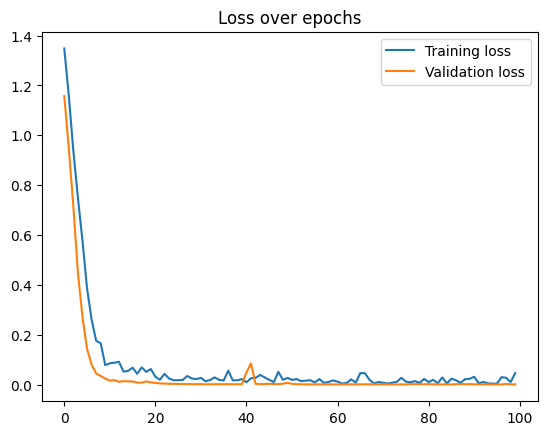

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

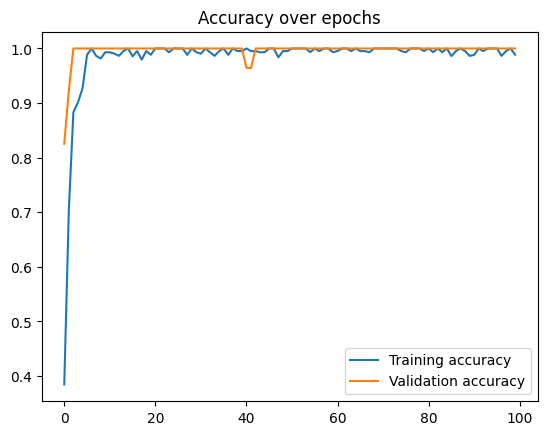

In [21]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Test Model with Seperated Test Data

In [22]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
test_data, test_labels = [], []

for dir_ in os.listdir(TEST_FOLDER_DIR):
    path = os.path.join(TEST_FOLDER_DIR, dir_)

    for img in os.listdir(path):
        image_tensor = transformed_image(os.path.join(path, img))
        test_data.append(image_tensor)
        test_labels.append(dir_)


In [24]:
test_dataset = SignDataset(test_data, test_labels)
len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

for data, label in test_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([35, 3, 300, 300])
torch.Size([35])


In [29]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            return outputs, labels

In [31]:
predicted, ground_truth = predict(model, test_dataloader)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.9643, device='cuda:0')
Precision: tensor(0.9750, device='cuda:0')
Recall: tensor(0.9643, device='cuda:0')
F1 Score: tensor(0.9676, device='cuda:0')


# Logging with MlFlow 

In [33]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.0001)
mlflow.log_param("weight_decay", 0.0001)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 100)
mlflow.log_param("traing_batch_size", 16)
mlflow.log_param("validation_batch_size", 16)

16

In [37]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("validation_accuracy", val_acc)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [35]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [36]:
# Log model
mlflow.pytorch.log_model(artifact_path="EfficientNet_Unfreeze", pytorch_model=model, registered_model_name="EfficientNet_Unfreeze")

2025/06/25 13:15:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 13:15:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 13:15:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Efficie